In [3]:
import sys

%load_ext autoreload
%autoreload 1
%aimport pygenesig.validation
%aimport pygenesig.gini
%aimport pygenesig.clevergini
%aimport pygenesig.bioqc
%aimport pygenesig.tools
%aimport pygenesig.perfmeasures
%matplotlib inline

from pygenesig.validation import * 
from pygenesig.gini import * 
from pygenesig.bioqc import * 
from pygenesig.tools import * 
from pygenesig.clevergini import * 
import pygenesig.perfmeasures as pm
import numpy as np
import pandas as pd
import sklearn.metrics as skm 
import os.path
import dask
from distributed import Client, progress
import dask.async
import dask.diagnostics

import seaborn as sns
sns.set_style("ticks", {"axes.grid" : True})
from pylab import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Crossvalidation of gini-signature on the GTEx dataset
In this document, we perform a 10-fold cross-validation of signature generation with gini-index. 

## Use dask for parallel computation

In [4]:
c = Client("10.114.185.14:8786")

In [5]:
expr_file = "../results/exprs_by_gene.npy"
target_file = "../results/target.csv"
fdata_file = "../results/fdata_by_gene.tsv"
splitter = sklearn.model_selection.StratifiedKFold(n_splits=10)
signature_generator = GiniSignatureGenerator
signature_tester = BioQCSignatureTester
sg_kwargs = {"min_gini": .8, "max_rk": 3, "min_expr": 5, "aggregate_fun": np.median}

In [6]:
exprs = np.load(expr_file)
target = np.genfromtxt(target_file, dtype=str, delimiter=",")
fdata = pd.read_csv(fdata_file, sep="\t", header=None, index_col=0)

In [7]:
sig_list, res_list, train_list, test_list = cv_score(expr_file,
                                                    target_file,
                                                    signature_generator,
                                                    signature_tester,
                                                    splitter,
                                                    sg_kwargs=sg_kwargs)

This is the dask compute graph executed internally: 

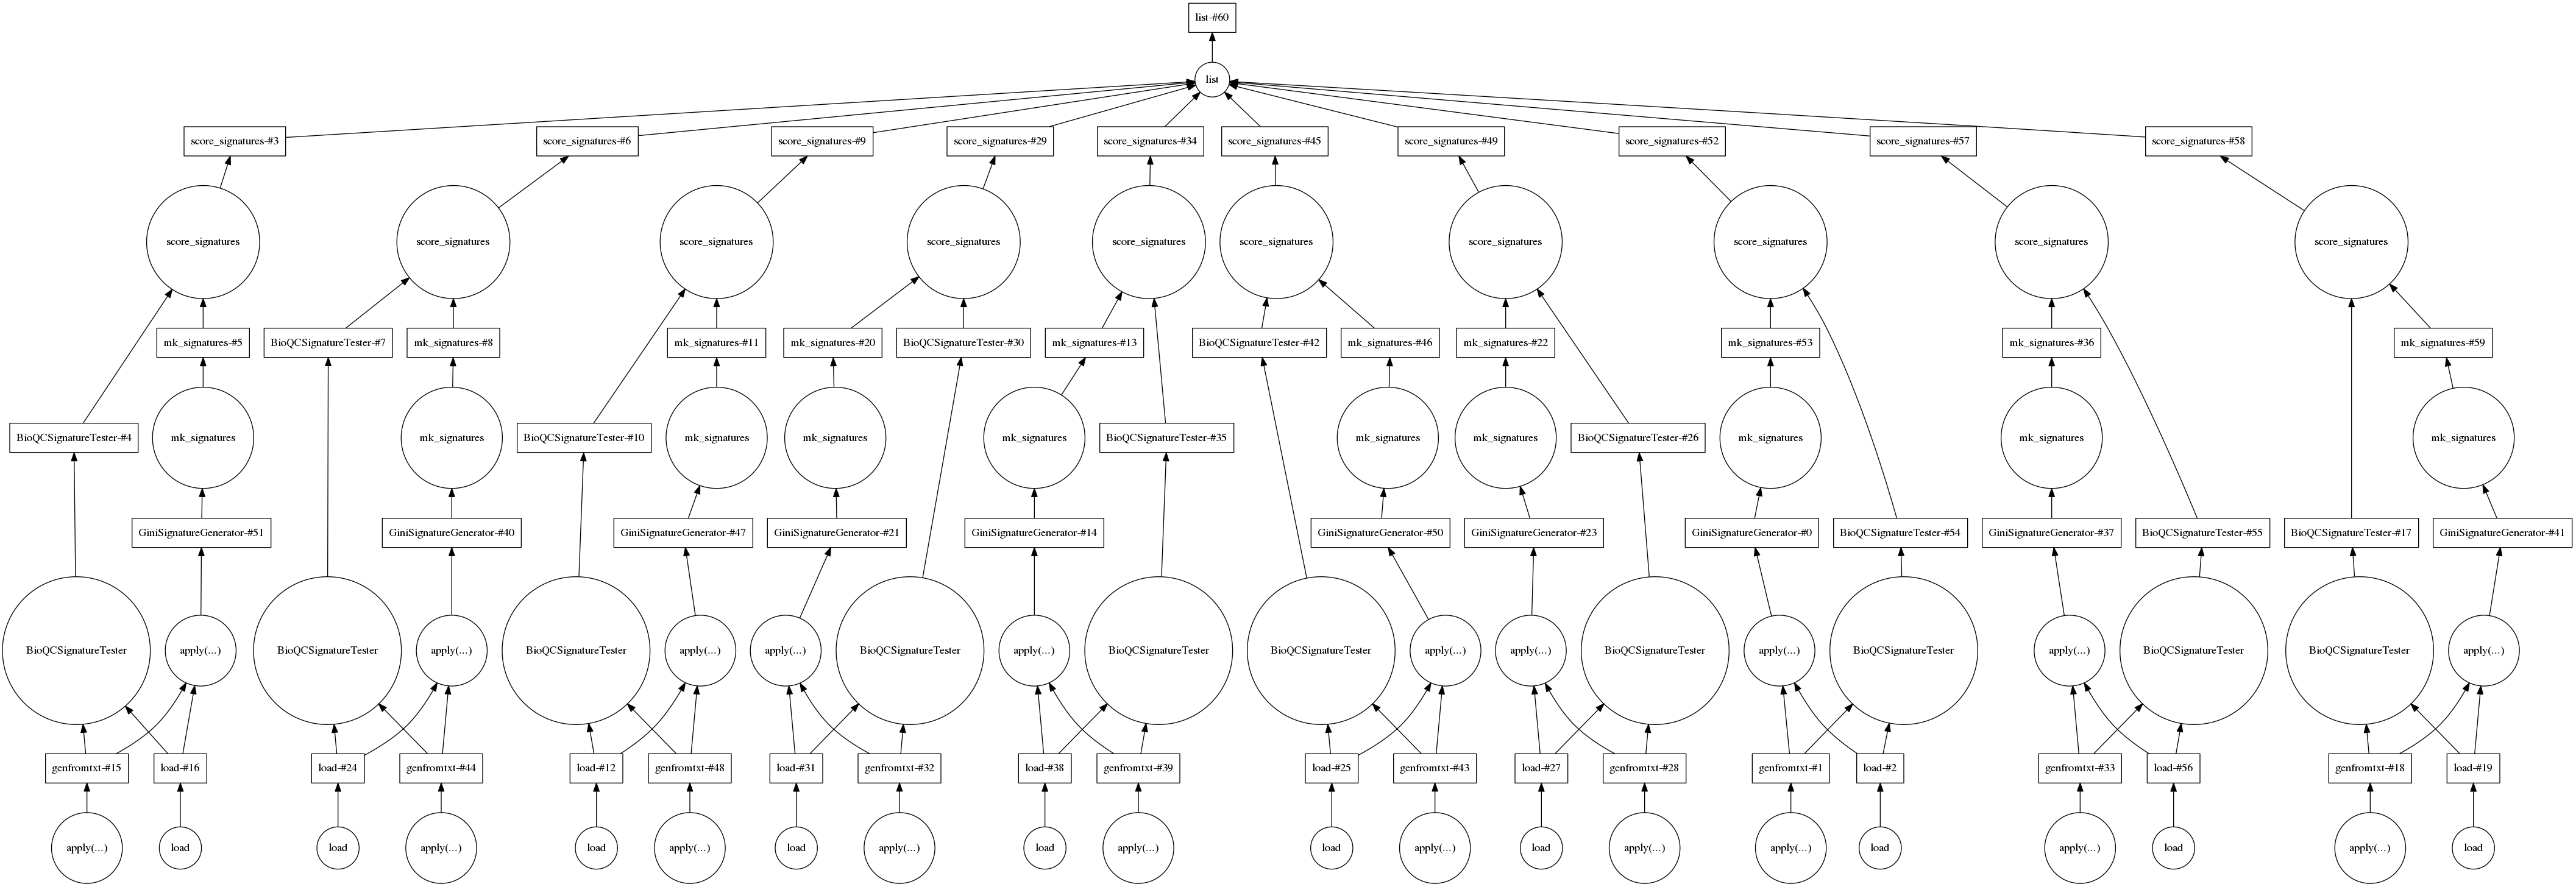

In [8]:
res_list.visualize()

Do the actual computation:

In [9]:
sig_f, res_f = c.compute([sig_list, res_list], sync=False)

In [10]:
progress([sig_f, res_f])

In [11]:
signatures = sig_f.result()

In [12]:
scores = res_f.result()

In [13]:
heatmaps = []
for i, test in enumerate(test_list):
    sig_labels = signature_tester.sort_signatures(signatures[i])
    scores_df = pd.DataFrame(np.transpose(scores[i]))
    scores_df.columns = sig_labels
    scores_df = scores_df.assign(tissue=pd.Series(target[test]))
    scores_per_sig = scores_df.groupby('tissue').mean().transpose()
    heatmaps.append(scores_per_sig)

In [14]:
heatmap_avg = np.mean([hm.as_matrix() for hm in heatmaps], axis=0)

In [15]:
heatmap_df = pd.DataFrame(heatmap_avg)
heatmap_df.index = heatmaps[0].index
heatmap_df.columns = heatmaps[0].columns

In [16]:
sns.set(font_scale=3)

/pstore/home/sturmg/projects/pygenesig/pygenesig/tools.py:218: RuntimeWarning: invalid value encountered in double_scalars
  array = [(x-amin)/(amax-amin) for x in array]


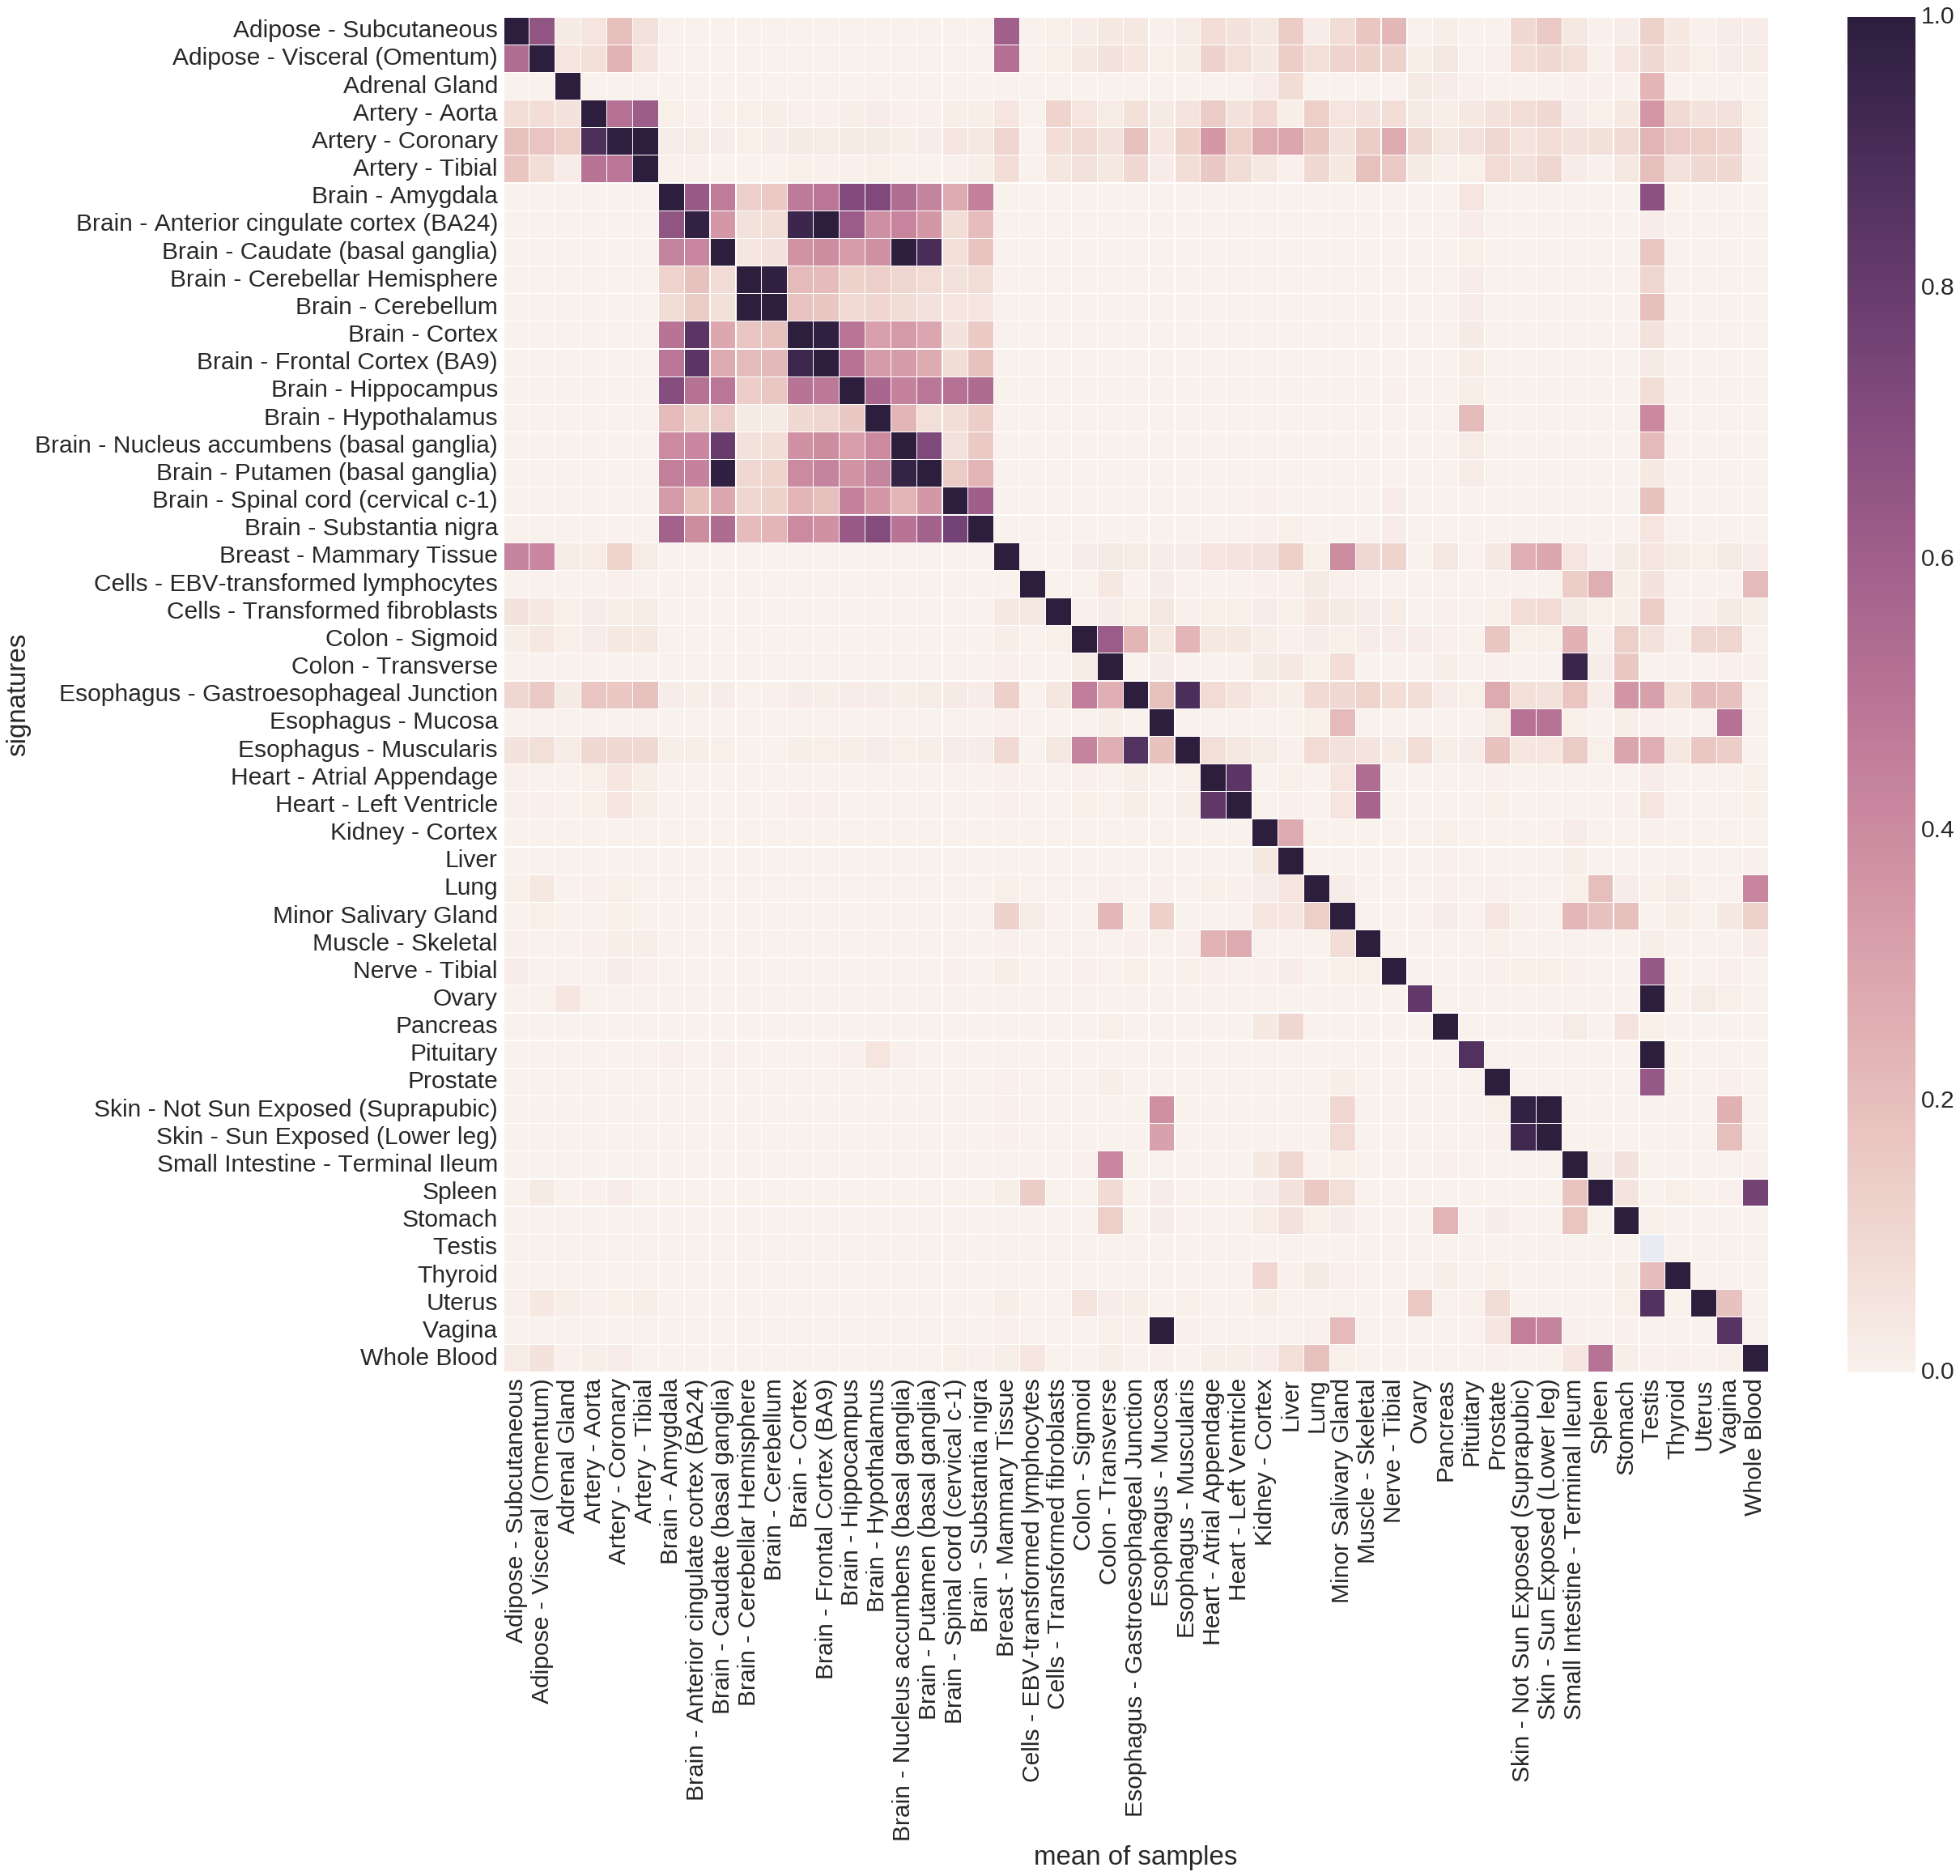

In [17]:
fig, ax = subplots(figsize=(35, 30))
sns.heatmap(heatmap_df.apply(normalize, axis=1, raw=True), ax=ax, annot=False, annot_kws={"size": 9}, vmin=0, linewidths=.2);
ax.set_ylabel("signatures")
ax.set_xlabel("mean of samples")

## Signature overlap between the folds
The box-plot shows the overlap of the signatures between the different folds. A high jaccard index indicates stability of the signatures between the folds. 

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP 'tcp://10.114.185.14:8786'>
tornado.application - ERROR - Exception in callback None
Traceback (most recent call last):
  File "/pstore/home/sturmg/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 886, in start
    fd_obj, handler_func = self._handlers[fd]
KeyError: 53


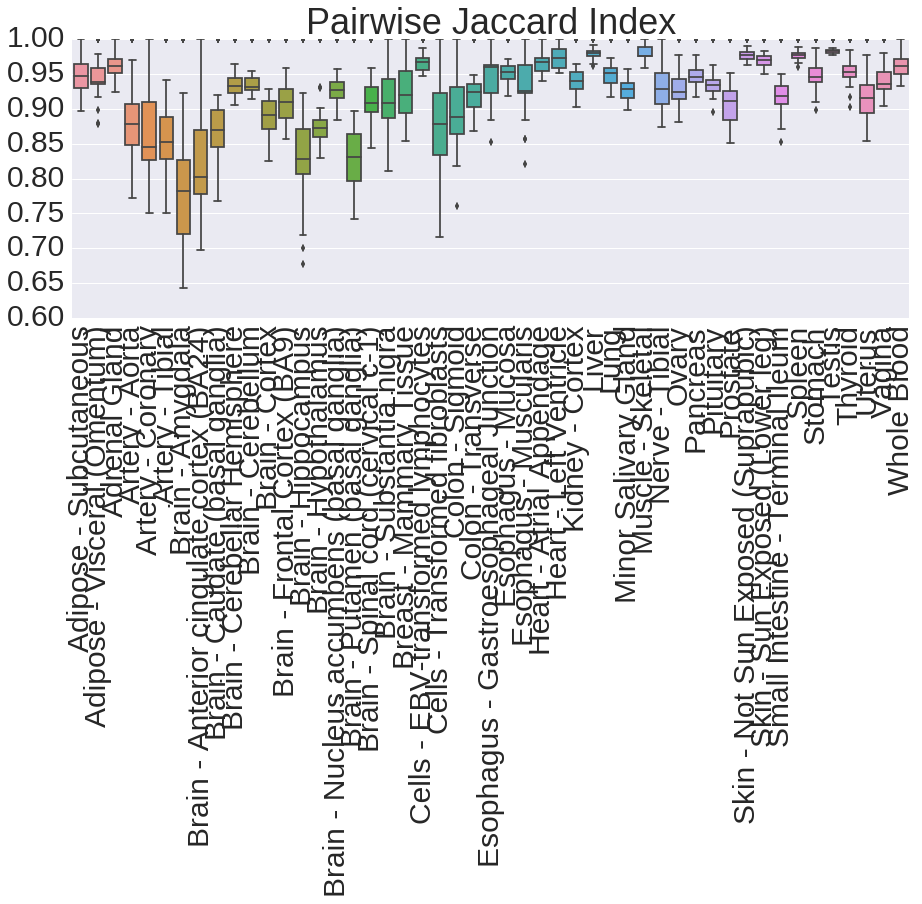

In [18]:
pairwise_jaccard = pairwise_jaccard_ind(signatures)
fig, ax = subplots(figsize=(15,5))
data=pd.DataFrame(pairwise_jaccard)
sns.boxplot(data=data, ax=ax)
ax.set_title("Pairwise Jaccard Index")
ax.set_xticklabels(data.columns, rotation=90);

## Export signatures

In [19]:
def mk_and_evaluate_signatures(expr, target):
    sg = GiniSignatureGenerator(expr, target, aggregate_fun=np.mean, min_expr=5, min_gini=.8, max_rk=3)
    st = BioQCSignatureTester(expr, target)
    signatures = sg.mk_signatures()
    rogini = "" # sg.get_rogini_format()
    scores = st.score_signatures(signatures)
    return signatures, rogini, scores

In [20]:
rosetta = dict(zip(fdata.index, fdata.iloc[:,0]))

In [21]:
signatures, rogini, scores = mk_and_evaluate_signatures(exprs, target)

/pstore/home/sturmg/projects/pygenesig/pygenesig/bioqc.py:157: RuntimeWarning: divide by zero encountered in log10
  bioqc_res_log = -np.log10(bioqc_res)


In [22]:
scores_df = pd.DataFrame(np.transpose(scores))
scores_df.columns = signature_tester.sort_signatures(signatures)
scores_df['tissue'] = pd.Series(target)
scores_per_sig = scores_df.groupby('tissue').median().transpose()

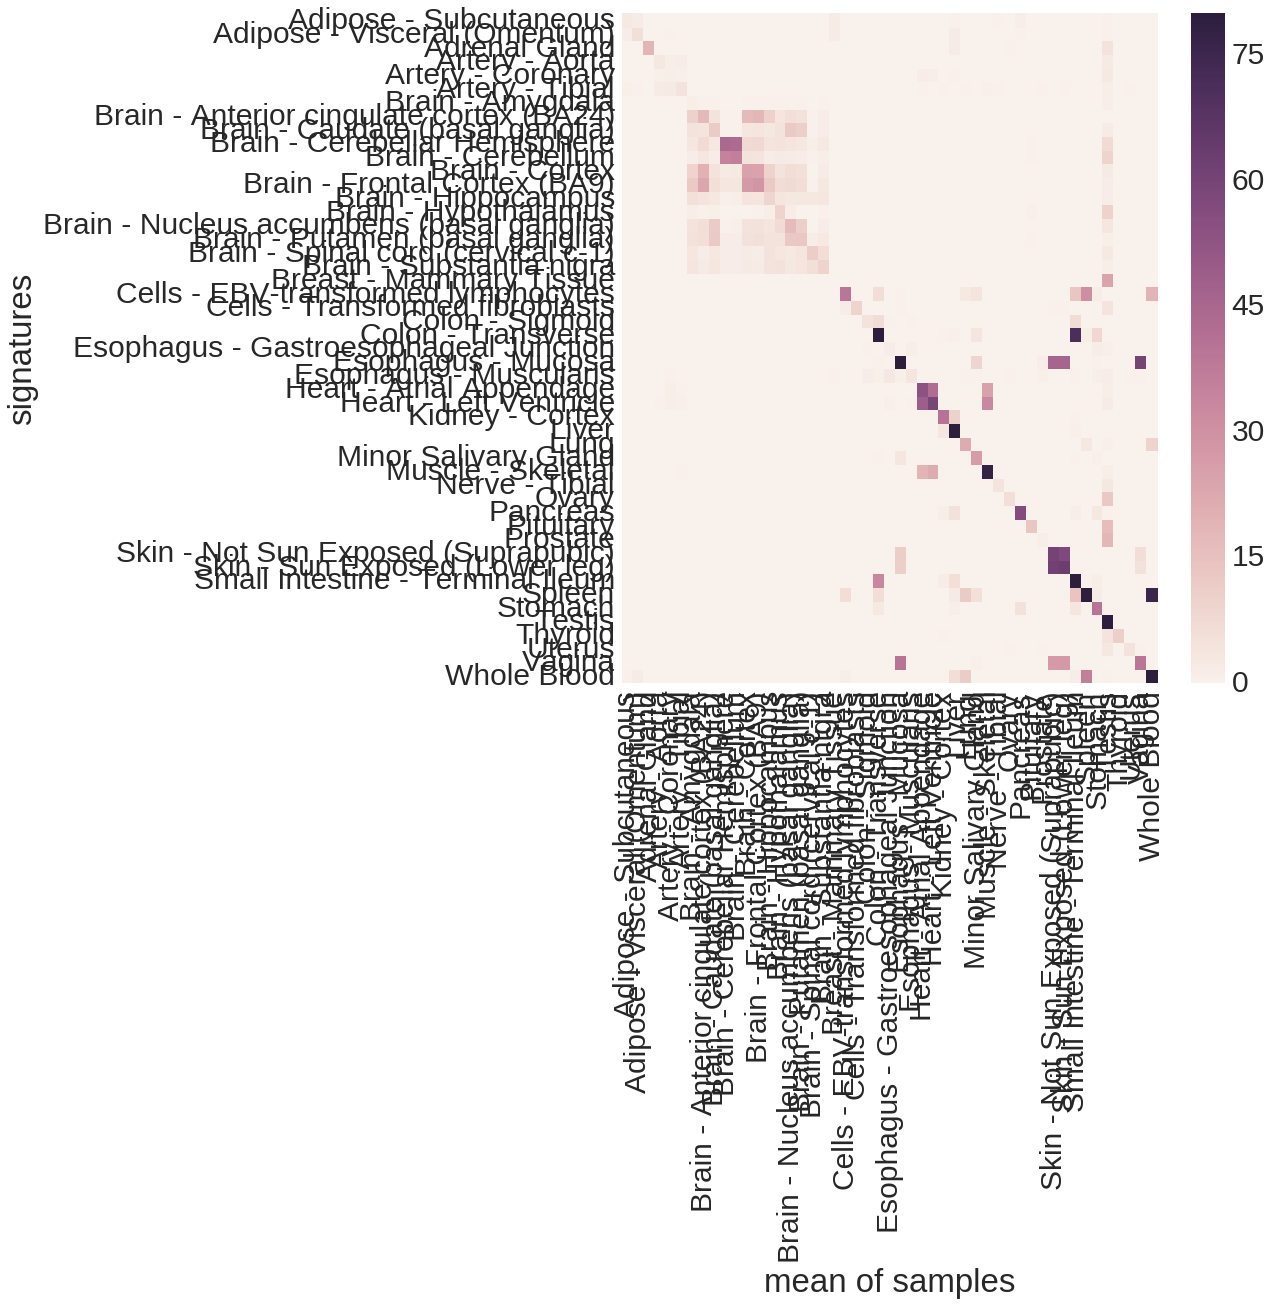

In [23]:
fig, ax = subplots(figsize=(12,12))
sns.heatmap(scores_per_sig, ax=ax, annot=False, annot_kws={"size": 9}, vmin=0, vmax=80);
ax.set_ylabel("signatures")
ax.set_xlabel("mean of samples")

In [24]:
jac_mat = jaccard_mat(signatures, signatures, as_matrix=True)

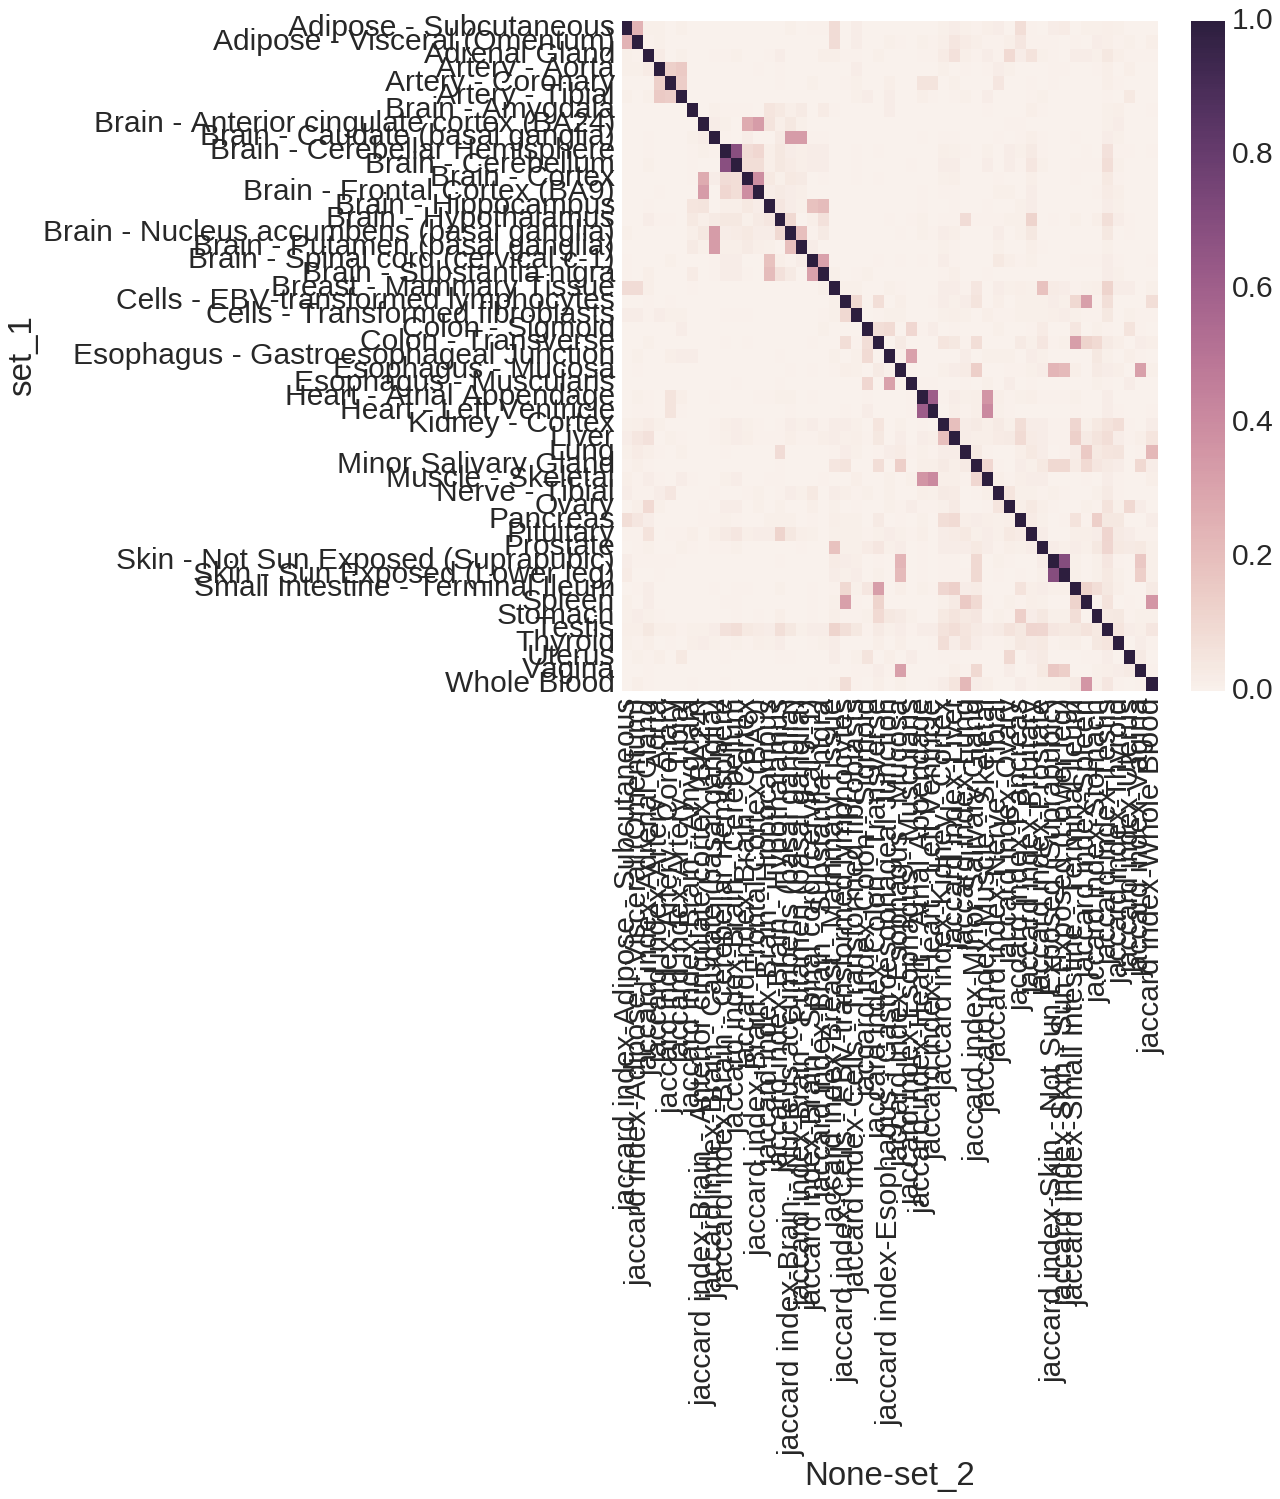

In [25]:
fig, ax = subplots(figsize=(12,12))
sns.heatmap(jac_mat, ax=ax)

In [26]:
signatures_hgnc = translate_signatures(signatures, rosetta)

In [117]:
write_gmt(signatures_hgnc, "../results/gtex_0.8_3.gmt")

In [118]:
print("\n".join(first(signatures_hgnc["Adipose Tissue"])))

NameError: name 'first' is not defined